# Qlora fine-tuning

In [9]:
#load variables from previous notebook
%store -r
print(training_input_path_domain)
print(training_input_path_instruct)
print(model_path)
print(model_name)
print(model_id)

s3://sagemaker-us-east-1-327216439222/model-fine-tuning/tokenized-domain/train/
s3://sagemaker-us-east-1-327216439222/model-fine-tuning/tokenized-instruct/train/
s3://sagemaker-us-east-1-327216439222/model-fine-tuning/models/falcon-7b/
falcon-7b
tiiuae/falcon-7b


In [1]:
#TODO:remove later
training_input_path_domain = "s3://sagemaker-us-east-1-327216439222/model-fine-tuning/tokenized-domain/train/"
training_input_path_instruct = "s3://sagemaker-us-east-1-327216439222/model-fine-tuning/tokenized-instruct/train/"
model_path = "s3://sagemaker-us-east-1-327216439222/model-fine-tuning/models/falcon-7b/"
model_name = "falcon-7b"
model_id = "tiiuae/falcon-7b"

In [2]:
!pip install huggingface_hub --upgrade --quiet
!pip install "transformers==4.30.2" "datasets[s3]==2.13.0" sagemaker --upgrade --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.157 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0.1 which is incompatible.


If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it.



In [3]:
#required to work in local_mode on your notebook instance for development/debugging purpose
#!pip install 'sagemaker[local]' --upgrade --quiet
#!pip install docker-compose --quiet

In [4]:
import sagemaker
import boto3
import os

#uncomment to run in local mode
#from sagemaker import LocalSession
#sess = LocalSession()
#the below help setting up the container's root on the EBS volume of your instance.
#sess.config = {'local' : {'local_code' : True, 'container_root' : '/home/ec2-user/SageMaker/'}}
#if you're running local mode and run into out of space issues, consider running docker_scripts/prepare-docker.sh to set the docker root under /home/ec2-user/SageMaker

sess = sagemaker.Session()
region = sess.boto_region_name

#replace the below by a specific bucket if you need
sagemaker_session_bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
s3_client = boto3.client("s3")
s3_prefix = "model-fine-tuning"

#local notebook path
notebook_home = "/home/ec2-user/SageMaker/"

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {region}")

sagemaker role arn: arn:aws:iam::327216439222:role/Sagemaker
sagemaker bucket: sagemaker-us-east-1-327216439222
sagemaker session region: us-east-1


## Fine-Tune with QLoRA on Amazon SageMaker

We are going to use the recently introduced method in the paper "[QLoRA: Quantization-aware Low-Rank Adapter Tuning for Language Generation](https://arxiv.org/abs/2106.09685)" by Tim Dettmers et al. QLoRA is a new technique to reduce the memory footprint of large language models during finetuning, without sacrificing performance. The TL;DR; of how QLoRA works is: 

* Quantize the pretrained model to 4 bits and freezing it.
* Attach small, trainable adapter layers. (LoRA)
* Finetune only the adapter layers, while using the frozen quantized model for context.

We prepared a [run_clm.py](./scripts/run_clm.py), which implements QLora using PEFT to train our model. The script also merges the LoRA weights into the model weights after training. That way you can use the model as a normal model without any additional code.

In order to create a sagemaker training job we need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. The Estimator manages the infrastructure use. 
SagMaker takes care of starting and managing all the required ec2 instances for us, provides the correct huggingface container, uploads the provided scripts and downloads the data from our S3 bucket into the container at `/opt/ml/input/data`. Then, it starts the training job by running.


In [5]:
print(f"model to be fine-tuned: {model_id}")

model to be fine-tuned: tiiuae/falcon-7b


### HF Estimator configuration

In [6]:
from sagemaker.huggingface import HuggingFace
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput
import time

def get_estimator(model_id):
    # define Training Job Name 
    job_name = f'huggingface-qlora-{time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())}'

    # hyperparameters, which are passed into the training job
    hyperparameters ={
      'model_id': model_id,                                # pre-trained model
      'dataset_path': '/opt/ml/input/data/training',       # path where sagemaker will save training dataset
      'model_path' : '/opt/ml/input/data/pre-trained/',    # path to load the model from
      'epochs': 4,                                         # number of training epochs
      'per_device_train_batch_size': 4,                    # batch size for training
      'lr': 2e-4,                                          # learning rate used during training
    }


    # create the Estimator for fine tuning on single GPU
    huggingface_estimator = HuggingFace(
        #sagemaker_session=sess,                   #required for setting new container root to EBS volume
        entry_point          = 'run_clm.py',         # train script
        source_dir           = './qlora_scripts',    # directory which includes all the files needed for training
        #instance_type        = 'local_gpu',         #uncomment and comment below to switch to local mode.
        instance_type        = 'ml.g5.12xlarge',     # instances type used for the training job
        instance_count       = 1,                 # the number of instances used for training
        base_job_name        = job_name,          # the name of the training job
        role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
        volume_size          = 500,               # the size of the EBS volume in GB
        transformers_version = '4.28.1',
        #framework_version    = '2.0.0',            # the transformers version used in the training job
        pytorch_version      = '2.0.0',            # the pytorch_version version used in the training job
        py_version           = 'py310',            # the python version used in the training job
        hyperparameters      =  hyperparameters,
        environment          = { "HUGGINGFACE_HUB_CACHE": "/tmp/.cache" }, # set env variable to cache models in /tmp
    )

    return huggingface_estimator
    '''
    # create the Estimator for fine tuning on multiple GPU (and local mode)
    huggingface_estimator = HuggingFace(
        sagemaker_session=sess,                   #required for setting new container root to EBS volume
        entry_point          = 'launch_accelerate.sh',         # train script
        source_dir           = './qlora_scripts',    # directory which includes all the files needed for training
        instance_type        = 'local_gpu',
        #instance_type        = 'ml.g5.12xlarge',     # instances type used for the training job
        instance_count       = 1,                 # the number of instances used for training
        base_job_name        = job_name,          # the name of the training job
        role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
        volume_size          = 400,               # the size of the EBS volume in GB
        transformers_version = '4.28.1',
        #framework_version    = '2.0.0',            # the transformers version used in the training job
        pytorch_version      = '2.0.0',            # the pytorch_version version used in the training job
        py_version           = 'py310',            # the python version used in the training job
        hyperparameters      =  hyperparameters,
        environment          = { "HUGGINGFACE_HUB_CACHE": "/tmp/.cache" }, # set env variable to cache models in /tmp
        #this configuration enabled data/model parallel distribution
        #distribution={
        #    "torch_distributed": {
        #        "enabled": True
        #    }
        #}
    )
    '''
    
def fit_model(huggingface_estimator, model_path, training_input_path):
    fast_file = lambda x: TrainingInput(x, input_mode="FastFile")
    huggingface_estimator.fit(
        {
            "pre-trained": fast_file(model_path),
            "training": fast_file(training_input_path),
        },
        wait=False,
    )
    training_job_name = huggingface_estimator.latest_training_job.name
    
    model_tar_gz_s3 = os.path.join("s3://", sagemaker_session_bucket, training_job_name, "output/model.tar.gz")
    
    return training_job_name, model_tar_gz_s3


def download_tuned_model(model_tuned_dir, training_job_name):
    if not os.path.isdir(model_tuned_dir):
        os.makedirs(model_tuned_dir)
    model_tuned_file = model_tuned_dir + "model.tar.gz"
 
    #download from s3 to local
    s3_client.download_file(sagemaker_session_bucket, 
                            os.path.join(training_job_name, "output/model.tar.gz"), 
                           model_tuned_file)
    return model_tuned_file

### Domain adaptation/fine tuning

We can now start our training job, with the `.fit()` method passing our S3 path to the training script.

In [7]:
#get estimator with config
huggingface_estimator_domain = get_estimator(model_id)

#launch fine tuning
training_job_name_domain, model_tar_gz_s3_domain = fit_model(huggingface_estimator_domain, model_path, training_input_path_domain)

print(f"training_job_name_domain:{training_job_name_domain}")
print(f"model_tar_gz_s3_domain:{model_tar_gz_s3_domain}")

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-qlora-2023-07-30-23-29-12-2023-07-30-23-29-12-389


Using provided s3_resource
training_job_name_domain:huggingface-qlora-2023-07-30-23-29-12-2023-07-30-23-29-12-389
model_tar_gz_s3_domain:s3://sagemaker-us-east-1-327216439222/huggingface-qlora-2023-07-30-23-29-12-2023-07-30-23-29-12-389/output/model.tar.gz


In our example, the SageMaker training job took 1h for one epoch. The ml.g5.12xlarge instance we used costs `$7.09 per hour` for on-demand usage.

Wait for the model to be fine tuned and model.tar.gz to be created or use one already created from folder: < TODO provide folder >

### Downloading the fine tuned model

In [11]:
model_tuned_domain_dir = os.path.join(notebook_home, "models", model_name + "-tuned-domain", "")
#download
model_tuned_domain_file = download_tuned_model(model_tuned_domain_dir, training_job_name_domain)

#untar to check the content and make sure it includes everything
!tar -xvf $model_tuned_domain_file --directory $model_tuned_domain_dir

generation_config.json
pytorch_model.bin.index.json
pytorch_model-00002-of-00002.bin
configuration_RW.py
config.json
code/
code/inference.py
code/requirements.txt
tokenizer_config.json
special_tokens_map.json
modelling_RW.py
pytorch_model-00001-of-00002.bin
tokenizer.json


## Instruct fine tuning

In [8]:
#get estimator with config
huggingface_estimator_instruct = get_estimator(model_id)

#launch fine tuning
training_job_name_instruct, model_tar_gz_s3_instruct = fit_model(huggingface_estimator_instruct, model_path, training_input_path_instruct)
print(f"training_job_name_domain:{training_job_name_instruct}")
print(f"model_tar_gz_s3_domain:{model_tar_gz_s3_instruct}")

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-qlora-2023-07-30-23-29-27-2023-07-30-23-29-27-188


Using provided s3_resource
training_job_name_domain:huggingface-qlora-2023-07-30-23-29-27-2023-07-30-23-29-27-188
model_tar_gz_s3_domain:s3://sagemaker-us-east-1-327216439222/huggingface-qlora-2023-07-30-23-29-27-2023-07-30-23-29-27-188/output/model.tar.gz


### Download the instruct fined tuned model

In [25]:
model_tuned_instruct_dir = os.path.join(notebook_home, "models", model_name + "-tuned-instruct", "")
#download
model_tuned_instruct_file = download_tuned_model(model_tuned_instruct_dir, training_job_name_instruct)

#untar to check the content and make sure it includes everything
!tar -xvf $model_tuned_domain_file --directory $model_tuned_domain_dir

generation_config.json
pytorch_model.bin.index.json
pytorch_model-00002-of-00002.bin
configuration_RW.py
config.json
code/
code/inference.py
code/requirements.txt
tokenizer_config.json
special_tokens_map.json
modelling_RW.py
pytorch_model-00001-of-00002.bin
tokenizer.json


### Fine tuning duration

it is interesting to note that the domain fine tuning with 4 epochs took only 3h compared to instruct fine tuning which took 8h

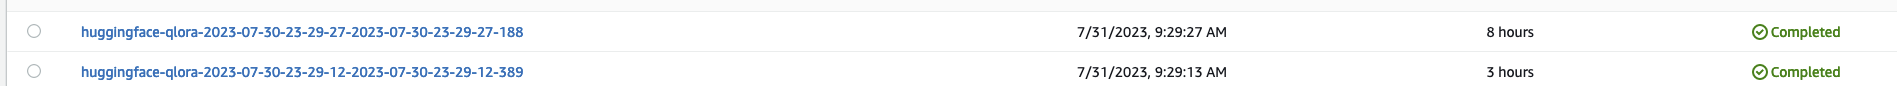

## Register model

### Create model group

In [26]:
sm_client = boto3.client('sagemaker', region_name=region)

def create_model_group(group_name, model_id):

    try:
        model_package_group_input_dict = {
         "ModelPackageGroupName" : group_name,
         "ModelPackageGroupDescription" : f"fine tuned versions of {model_id}"
        }
        create_model_package_group_response = sm_client.create_model_package_group(**model_package_group_input_dict)
        print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))
        return create_model_package_group_response['ModelPackageGroupArn']
    except:
        print("Model group already exists")

In [27]:
model_package_group_name_domain = "gai-fine-tuned-domain-" + model_name
modelPackageGroupArn_domain = create_model_group(model_package_group_name_domain, model_id)

Model group already exists


In [28]:
model_package_group_name_instruct = "gai-fine-tuned-instruct-" + model_name
modelPackageGroupArn_instruct = create_model_group(model_package_group_name_instruct, model_id)

Model group already exists


### Register a model version

In [29]:
image_url = "763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:2.0.0-transformers4.28.1-gpu-py310-cu118-ubuntu20.04"

def register_model_version(image_url, model_tar_gz_s3, model_package_group_name, model_id, training_job_name):
    modelpackage_inference_specification =  {
        "InferenceSpecification": {
          "Containers": [
             {
                "Image": image_url,
                 "ModelDataUrl": model_tar_gz_s3
             }
          ],
          "SupportedContentTypes": ["application/json"],
          "SupportedResponseMIMETypes": ["application/json"],
       }
     }

    create_model_package_input_dict = {
        "ModelPackageGroupName" : model_package_group_name,
        "ModelPackageDescription" : f"qlora fine tuning of model {model_id} done during training job {training_job_name}",
        "ModelApprovalStatus" : "PendingManualApproval"
    }

    create_model_package_input_dict.update(modelpackage_inference_specification)
    print(f"model package configuration:{create_model_package_input_dict}")
    
    create_model_package_response = sm_client.create_model_package(**create_model_package_input_dict)
    model_package_arn = create_model_package_response["ModelPackageArn"]
    print('ModelPackage Version ARN : {}'.format(model_package_arn))
    return model_package_arn

In [30]:
model_package_arn_domain = register_model_version(image_url, model_tar_gz_s3_domain, model_package_group_name_domain, model_id, training_job_name_domain)

model package configuration:{'ModelPackageGroupName': 'gai-fine-tuned-domain-falcon-7b', 'ModelPackageDescription': 'qlora fine tuning of model tiiuae/falcon-7b done during training job huggingface-qlora-2023-07-30-23-29-12-2023-07-30-23-29-12-389', 'ModelApprovalStatus': 'PendingManualApproval', 'InferenceSpecification': {'Containers': [{'Image': '763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:2.0.0-transformers4.28.1-gpu-py310-cu118-ubuntu20.04', 'ModelDataUrl': 's3://sagemaker-us-east-1-327216439222/huggingface-qlora-2023-07-30-23-29-12-2023-07-30-23-29-12-389/output/model.tar.gz'}], 'SupportedContentTypes': ['application/json'], 'SupportedResponseMIMETypes': ['application/json']}}
ModelPackage Version ARN : arn:aws:sagemaker:us-east-1:327216439222:model-package/gai-fine-tuned-domain-falcon-7b/3


In [31]:
model_package_arn_instruct = register_model_version(image_url, model_tar_gz_s3_instruct, model_package_group_name_instruct, model_id, training_job_name_instruct)

model package configuration:{'ModelPackageGroupName': 'gai-fine-tuned-instruct-falcon-7b', 'ModelPackageDescription': 'qlora fine tuning of model tiiuae/falcon-7b done during training job huggingface-qlora-2023-07-30-23-29-27-2023-07-30-23-29-27-188', 'ModelApprovalStatus': 'PendingManualApproval', 'InferenceSpecification': {'Containers': [{'Image': '763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:2.0.0-transformers4.28.1-gpu-py310-cu118-ubuntu20.04', 'ModelDataUrl': 's3://sagemaker-us-east-1-327216439222/huggingface-qlora-2023-07-30-23-29-27-2023-07-30-23-29-27-188/output/model.tar.gz'}], 'SupportedContentTypes': ['application/json'], 'SupportedResponseMIMETypes': ['application/json']}}
ModelPackage Version ARN : arn:aws:sagemaker:us-east-1:327216439222:model-package/gai-fine-tuned-instruct-falcon-7b/3


In [32]:
sm_client.list_model_packages(ModelPackageGroupName=model_package_group_name_domain)

{'ModelPackageSummaryList': [{'ModelPackageGroupName': 'gai-fine-tuned-domain-falcon-7b',
   'ModelPackageVersion': 3,
   'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:327216439222:model-package/gai-fine-tuned-domain-falcon-7b/3',
   'ModelPackageDescription': 'qlora fine tuning of model tiiuae/falcon-7b done during training job huggingface-qlora-2023-07-30-23-29-12-2023-07-30-23-29-12-389',
   'CreationTime': datetime.datetime(2023, 8, 1, 1, 35, 24, 446000, tzinfo=tzlocal()),
   'ModelPackageStatus': 'Completed',
   'ModelApprovalStatus': 'PendingManualApproval'},
  {'ModelPackageGroupName': 'gai-fine-tuned-domain-falcon-7b',
   'ModelPackageVersion': 2,
   'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:327216439222:model-package/gai-fine-tuned-domain-falcon-7b/2',
   'ModelPackageDescription': 'qlora fine tuning of model tiiuae/falcon-7b done during training job huggingface-qlora-2023-07-30-23-29-12-2023-07-30-23-29-12-389',
   'CreationTime': datetime.datetime(2023, 8, 1, 1, 16, 

In [33]:
sm_client.list_model_packages(ModelPackageGroupName=model_package_group_name_instruct)

{'ModelPackageSummaryList': [{'ModelPackageGroupName': 'gai-fine-tuned-instruct-falcon-7b',
   'ModelPackageVersion': 3,
   'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:327216439222:model-package/gai-fine-tuned-instruct-falcon-7b/3',
   'ModelPackageDescription': 'qlora fine tuning of model tiiuae/falcon-7b done during training job huggingface-qlora-2023-07-30-23-29-27-2023-07-30-23-29-27-188',
   'CreationTime': datetime.datetime(2023, 8, 1, 1, 35, 27, 193000, tzinfo=tzlocal()),
   'ModelPackageStatus': 'Completed',
   'ModelApprovalStatus': 'PendingManualApproval'},
  {'ModelPackageGroupName': 'gai-fine-tuned-instruct-falcon-7b',
   'ModelPackageVersion': 2,
   'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:327216439222:model-package/gai-fine-tuned-instruct-falcon-7b/2',
   'ModelPackageDescription': 'qlora fine tuning of model tiiuae/falcon-7b done during training job huggingface-qlora-2023-07-30-23-29-27-2023-07-30-23-29-27-188',
   'CreationTime': datetime.datetime(2023, 8, 1,

### Approve model

In [34]:
def approve_model(model_package_arn):
    model_package_update_input_dict = {
        "ModelPackageArn" : model_package_arn,
        "ModelApprovalStatus" : "Approved"
    }
    model_package_update_response = sm_client.update_model_package(**model_package_update_input_dict)

In [35]:
approve_model(model_package_arn_domain)

In [36]:
approve_model(model_package_arn_instruct)

In [37]:
%store model_package_arn_domain
%store model_package_arn_instruct
%store model_tar_gz_s3_instruct
%store model_tar_gz_s3_domain

Stored 'model_package_arn_domain' (str)
Stored 'model_package_arn_instruct' (str)
Stored 'model_tar_gz_s3_instruct' (str)
Stored 'model_tar_gz_s3_domain' (str)
